In [270]:
import jax
import jax.numpy as jnp
from tqdm import tqdm
import netket as nk
# import netket_pro as nkp
import matplotlib.pyplot as plt
import os

In [271]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [272]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [273]:
from grad_sample.utils.plotting_setup import *

In [275]:
model_key= "xxz_1.5"
L = 14
diag_shift = 3

# model_key = "ising_1.0"
# L=3
# diag_shift = 10

# model_key = "heisenberg1d_1.0_s0"
# L=14
# diag_shift = 4

In [276]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate
from grad_sample.tasks.fullsum_analysis import FullSumPruning

strategy = "curved_dist"

if GlobalHydra().is_initialized():
    GlobalHydra().clear()
with initialize(version_base=None, config_path="config_xxz/.hydra/"):
    cfg = compose(config_name="config")
    OmegaConf.set_struct(cfg, True)
    print(cfg)
    print(type(cfg.task))
    # cfg = OmegaConf.to_yaml(cfg)
    # take any task from cfg and run it
analysis = FullSumPruning(cfg)
    
# # global initialization
# initialize(version_base=None, config_path="conf", job_name="test_app")
# cfg = compose(config_name="config", overrides=["db=mysql", "db.user=me"])
# print(OmegaConf.to_yaml(cfg))

{'device': '4', 'solver_fn': {'_target_': 'netket.optimizer.solver.cholesky'}, 'lr': 0.005, 'n_iter': 2000, 'chunk_size_jac': 5000, 'chunk_size_vmap': 100, 'save_every': 10, 'sample_size': 0, 'base_path': '/scratch/.amisery/grad_sample/', 'model': {'_target_': 'grad_sample.models.heisenberg.XXZ', 'h': 1.5, 'L': 14}, 'diag_shift': 0.001, 'ansatz': {'_target_': 'netket.models.RBM', 'alpha': 1, 'param_dtype': 'complex'}, 'task': {'_target_': 'grad_sample.tasks.fullsum_train.Trainer'}}
<class 'omegaconf.dictconfig.DictConfig'>
{'_target_': 'netket.models.RBM', 'alpha': 1, 'param_dtype': 'complex'}
1
3432
3432
The ground state energy is: -29.5592099341575
[1.e+00 1.e-01 1.e-02 1.e-03 1.e-04]
[Array(2, dtype=int64), Array(4, dtype=int64), Array(51, dtype=int64), Array(76, dtype=int64), Array(199, dtype=int64)]


/scratch/.amisery/netket/lib/python3.11/site-packages/netket/vqs/full_summ/state.py:240: UserWarning: For performance reasons, we suggest to use a power-of-two chunk size.
  warnings.warn(


In [277]:
# analysis.set_strategy()
# from tqdm import tqdm
# import jax.numpy as jnp
# import jax
# fs_dist_pdf = []
# for state_idx in tqdm(analysis.eval_s):
#     # todo : add delta dependency
#     analysis.load_state(state_idx)
#     pdf_out, out = jax.lax.scan(analysis.prune_to, analysis.pdf, jnp.argsort(analysis.pdf))
#     fs_dist_pdf.append(out[1])

In [278]:
# analysis.set_strategy()
# from tqdm import tqdm
# import jax.numpy as jnp
# import jax
# fs_dist_hloc = []
# for state_idx in tqdm(analysis.eval_s):
#     # todo : add delta dependency
#     analysis.load_state(state_idx)
#     pdf_out, out = jax.lax.scan(analysis.prune_to, analysis.pdf, jnp.argsort(jnp.abs(analysis.Hloc_c)*analysis.pdf))
#     fs_dist_hloc.append(out[1])

In [279]:
def plot_multi_alpha(alpha, strategy="curved_dist", n_err=9, model_key="ising_1.0", L=3):
    path= f"/scratch/.amisery/grad_sample/{model_key}/L{L}/RBM/alpha{alpha}/saved_10_3/out_analysis_oneshot_{strategy}.npz"
    dict_l = jnp.load(path, allow_pickle=True)["arr_0"].item()
    
    delta= dict_l["commons"]["delta"]
    fig, axes = plt.subplots(1, n_err, figsize=(20,3))
    out_dict = dict_l 
    for j in range(n_err):

        keys = list(out_dict.keys())[1:]
         # keys  = jnp.argwhere(keys.type == int)
        if j< len(list(out_dict.keys())):
            axes[j].plot(out_dict[keys[j]]["infid_ev"], label = r"$\alpha = %d$"%alpha)
            axes[j].set_yscale("log")
            axes[j].set_title(r"$\sigma_{rel} \approx 10^{-%d},\newline \delta =%.1e$"%(j, out_dict[keys[j]]["delta"]), fontsize=15)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.98,0.9))
    fig.suptitle(r"Robustness of $\frac{FS(\ket{\psi_{\theta+\delta \dot{\theta}}}, (I -\delta H) \ket{\psi_\theta})}{FS(\ket{\psi_{\theta}}, (I -\delta H) \ket{\psi_\theta})}$ to sample pruning, $\delta = %.2e$"%delta, y=1.3, fontsize=23)
    return fig, axes

In [280]:
# # model_key = "ising_1.0"
# # L=3
# model_key= "xxz_1.5"
# L=14
# n_err = 5
# fig, axes = plot_multi_alpha(1, model_key=model_key, L=L, n_err=n_err)
# for i in range(min(len(fs_dist_pdf), n_err)):
#     axes[i].plot(fs_dist_pdf[i], label = "pdf strategy", color="orange")
#     # axes[i].plot(fs_dist_hloc[i], label = "Hloc strategy", color="green")
#     axes[i].set_yscale("log")
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, bbox_to_anchor=(0.98,0.9))
# # plt.legend()
# plt.show()

In [350]:
# plot_multi_alpha(8, "infidelity")
from jax.numpy.linalg import pinv
from grad_sample.utils.distances import fs_dist
def pdf(dict, vals):
    return dict["pdf"][vals], r"$|\psi(\sigma)|^2$"

def gradient(dict, vals):
    jac_c = dict["jac"] - jnp.sum(dict["pdf"][:,None]*dict["jac"], axis=0)
    return jnp.sum(jac_c, axis=0)[vals], "gradient"

def hpsi(dict, vals):
    v_arr = dict["vs_arr"]
    hpsi = dict["Hloc"]*v_arr
    return hpsi[vals], r"$H \ket{\psi}$"

def hloc(dict, vals):
    hloc = dict["Hloc"] - jnp.sum(dict["pdf"]*dict["Hloc"])
    return hloc[vals], r"$\Delta H_{loc}(\sigma)$"

def best_estim_qgt(dict, vals):
    pdf = dict["pdf"]
    hloc = dict["Hloc"] - jnp.sum(pdf*dict["Hloc"])
    jac_c = dict["jac"] - jnp.sum(pdf[:,None]*dict["jac"], axis=0)

    product = jnp.einsum('is,sj->ij', jac_c.conj().T, jac_c)
    norm = jnp.sqrt(jnp.sum(jnp.abs(product)**2, axis=0))
    return pdf[vals]*norm[vals]/(jnp.sum(pdf[vals]*norm[vals])), "Best QGT IS proposal distribution"

def best_estim_force(dict, vals):
    pdf = dict["pdf"]
    hloc = dict["Hloc"] - jnp.sum(pdf*dict["Hloc"])
    jac_c = dict["jac"] - jnp.sum(pdf[:,None]*dict["jac"], axis=0)

    norm = jnp.linalg.norm(jac_c.conj().T @ hloc)
    ret = pdf*norm/(jnp.sum(norm*pdf))
    return ret[vals], "Best Force IS proposal distribution"

    
def ntk(dict, vals):
    pdf = dict["pdf"]
    ret = []
    for i in  range(1,len(vals), len(vals)//100):
        pdf_r = pdf.at[vals[:i]].set(0)
        pdf_r = pdf_r / jnp.sum(pdf_r)
        jac_c = dict["jac"] - jnp.sum(pdf_r[:,None]*dict["jac"], axis=0)
        ntk = jac_c @ jac_c.conj().T
        hpsi = dict["Hloc"]*dict["vs_arr"]
        delta_H_psi = hpsi - jnp.sum(pdf_r*hpsi)
        ret.append(fs_dist(delta_H_psi, ntk @ delta_H_psi))

    return jnp.array(ret), r"$FS(\Delta H \ket{\psi},  K_S \Delta H \ket{\psi})$"

def ntk_inv(dict, vals):
    pdf = dict["pdf"]
    ret = []
    for i in  range(1,len(vals), len(vals)//10):
        pdf_r = pdf.at[vals[:i]].set(0)
        pdf_r = pdf_r / jnp.sum(pdf_r)
        jac_c = jnp.sqrt(pdf_r[:,None]) *(dict["jac"] - jnp.sum(pdf_r[:,None]*dict["jac"], axis=0))
        ntk = jac_c @ jac_c.conj().T
        hpsi = dict["Hloc"]*dict["vs_arr"]
        delta_H_psi = hpsi - jnp.sum(pdf_r*hpsi)
        inv  = pinv(ntk)
        ret.append(fs_dist(delta_H_psi, inv @ delta_H_psi))
    return jnp.array(ret), r"$\bra{\psi} \Delta H K_s^{-1} \Delta H \ket{\psi}$"

def ntk_sr(dict, vals):
    pdf = dict["pdf"]
    ret = []
    v_arr = dict["vs_arr"]
    hpsi = dict["Hloc"]*dict["vs_arr"]
    delta_H_psi = hpsi - jnp.sum(pdf*hpsi)
    for i in  range(1,len(vals), len(vals)//10):
        pdf_r = pdf.at[vals[:i]].set(0)
        pdf_r = pdf_r / jnp.sum(pdf_r)
        jac_c = v_arr_r[:,None]*(dict["jac"]) - jnp.sum(pdf_r[:,None]*(dict["jac"]*v_arr_r[:,None]), axis=0)
        ntk = jac_c @ jac_c.conj().T
        inv = 1/(1e-10)*ntk @ pinv(jnp.eye(ntk.shape[0]) + ntk/(1e-10))
        ret.append(fs_dist(pdf_r * delta_H_psi, pdf_r * inv @ delta_H_psi))
    return jnp.array(ret), r"$FS(\Delta H \ket{\psi}, (I + \lambda K_S^{-1})^{-1} \Delta H \ket{\psi})$"

def ntk_sq(dict, vals):
    pdf = dict["pdf"]
    ret = []
    v_arr = dict["vs_arr"]
    hpsi = dict["Hloc"]*dict["vs_arr"]
    delta_H_psi = hpsi - jnp.sum(pdf*hpsi)
    for i in  tqdm(range(1,len(vals), len(vals)//10)):
        pdf_r = pdf.at[vals[:i]].set(0)
        nf = jnp.sum(pdf_r)
        pdf_r = pdf_r / nf
        v_arr_r = v_arr.at[vals[:i]].set(0)/jnp.sqrt(nf)
        jac_c = v_arr_r[:,None]*(dict["jac"]) - jnp.sum(pdf_r[:,None]*(dict["jac"]*v_arr_r[:,None]), axis=0)
        
        # print(jac_orth.shape)
        ntk = jac_c @ jac_c.conj().T
        # qgt = jac_c.conj().T @ jac_c
        # ntk_orth = jac_c @ pinv(qgt) @ jac_c.conj().T
        ntk_sq = ntk.conj().T @ ntk
        # print(ntk_sq / ntk_orth)

        ret.append((delta_H_psi.conj().transpose() @ ntk_sq @ delta_H_psi)/(delta_H_psi.conj().transpose() @ delta_H_psi))
        
    return  jnp.array(ret), r"$\frac{\bra{\psi} \Delta H K_s^2 \Delta H \ket{\psi}}{\bra{\psi} \Delta H \Delta H \ket{\psi}}$"

def ntk_orth(dict, vals):
    pdf = dict["pdf"]
    ret = []

    v_arr = dict["vs_arr"]
    hpsi = dict["Hloc"]*v_arr
    delta_H_psi = hpsi - jnp.sum(pdf*hpsi)
    jac_c = v_arr[:,None]*(dict["jac"]) - jnp.sum(pdf[:,None]*(dict["jac"]*v_arr[:,None]), axis=0)
    qgt = jac_c.conj().T @ jac_c
    ntk_orth_true = jac_c @ pinv(qgt + diag_shift*jnp.eye(qgt.shape[0])) @ jac_c.conj().T 
    for i in  tqdm(range(1,len(vals), len(vals)//10)):
    
        pdf_r = pdf.at[vals[:i]].set(0)
        nf = jnp.sum(pdf_r)
        pdf_r = pdf_r / nf
        v_arr_r = v_arr.at[vals[:i]].set(0)/jnp.sqrt(nf)
        
        jac_c = v_arr_r[:,None]*(dict["jac"]) - jnp.sum(pdf_r[:,None]*(dict["jac"]*v_arr_r[:,None]), axis=0)
        # jac_c = pdf_r[:,None]*(dict["jac"] - jnp.sum(pdf_r[:,None]*dict["jac"], axis=0))
        # jac_c = orth(jac_c)

        # print(jac_orth.shape)
        # ntk = jac_c @ jac_c.conj().T
        qgt = jac_c.conj().T @ jac_c
        ntk_orth = jac_c @ pinv(qgt) @ jac_c.conj().T

        # hpsi = dict["Hloc"]*v_arr_r
        # delta_H_psi =hpsi - jnp.sum(pdf_r*hpsi) 
        
        ret.append(fs_dist(ntk_orth_true @ ntk_orth @ delta_H_psi,delta_H_psi))
        
    return  jnp.array(ret), r"$FS(K_{s,orth} \Delta H \ket{\psi}, \Delta H \ket{\psi})$"

def ntk_orth_tot_diagshift(dict, diag_shift):
    pdf = dict["pdf"]
    v_arr = dict["vs_arr"]
    jac_c = v_arr[:,None]*(dict["jac"]) - jnp.sum(pdf[:,None]*(dict["jac"]*v_arr[:,None]), axis=0)
    qgt = jac_c.conj().T @ jac_c
    ntk_orth = jac_c @ pinv(qgt + diag_shift*jnp.eye(qgt.shape[0])) @ jac_c.conj().T
    # print(ntk_sq / ntk_orth)
    # hpsi = dict["Hloc"]*dict["vs_arr"]
    hpsi = dict["Hloc"]*v_arr
    delta_H_psi = hpsi - jnp.sum(pdf*hpsi)
    return jnp.linalg.norm(ntk_orth @ delta_H_psi)/jnp.linalg.norm(delta_H_psi)

In [356]:
def plot_multi_val_fixed_alpha(alpha=5, key="ntk_sq", n_err = 5, strategy="curved_dist", model_key="ising_1.0", diag_shift=10, L=3):
    path= f"/scratch/.amisery/grad_sample/{model_key}/L{L}/RBM/alpha{alpha}/saved_10_{diag_shift}/out_analysis_oneshot_{strategy}.npz"
    out_dict= jnp.load(path, allow_pickle=True)["arr_0"].item()
    keys = list(out_dict.keys())[1:]
    delta= out_dict["commons"]["delta"]
    fig, axes = plt.subplots(1, n_err, figsize=(20,5))
    for j in range(n_err):
        # plot curved_dist strat
        analysis.load_state(analysis.eval_s[j])
        jac_c = analysis.jacobian_orig - jnp.sum(analysis.jacobian_orig*analysis.pdf[:,None],axis=0)
        # vals_list = [jnp.argsort(analysis.pdf), jnp.argsort(jnp.abs(analysis.Hloc_c)), jnp.argsort(jnp.linalg.norm(jac_c, axis=1))]
        # vals_labels = [r"$|\psi(\sigma)|^2$", r"$|\Delta H_{loc}(\sigma)|$", r'$|Grad \Delta \log \psi(\sigma)|$']
        vals_list = [jnp.argsort(analysis.pdf)]
        vals_labels = [r"$|\psi(\sigma)|^2$"]

        # keys  = jnp.argwhere(keys.type == int)
        if j < len(keys):
            vals = out_dict[keys[j]]["in_idx"]
    
            obs, name = globals()[key](out_dict[keys[j]], vals)
            axes[j].scatter(jnp.arange(len(obs)), jnp.abs(obs), label = "curved dist strategy")
            axes[j].set_yscale("log")
            axes[j].set_ylabel(name)
            axes[j].set_title(r"$\sigma_{rel} \approx 10^{-%d},\newline \delta =%.1e$"%(j, out_dict[keys[j]]["delta"]), fontsize=15)

            for i in range(len(vals_list)):
                obs, name = globals()[key](out_dict[keys[j]], vals_list[i])
                axes[j].scatter(jnp.arange(len(obs)), jnp.abs(obs), label = vals_labels[i])
                axes[j].set_yscale("log")
                axes[j].set_ylabel(name)
                axes[j].set_title(r"$\sigma_{rel} \approx 10^{-%d},\newline \delta =%.1e$"%(j, out_dict[keys[j]]["delta"]), fontsize=15)

    handles, labels = [], []
    for ax in axes.flat:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    unique = dict(zip(labels, handles))
    fig.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.2,0.9))
    fig.suptitle(name + " over pruning, for several relative errors and models", fontsize=20)
    plt.tight_layout()
    

In [351]:
def ntk_orth_several_errors( n_err = 5, strategy="curved_dist", model_key="ising_1.0", diag_shift=10, L=3):
    path= f"/scratch/.amisery/grad_sample/{model_key}/L{L}/RBM/alpha{1}/saved_10_{diag_shift}/out_analysis_oneshot_{strategy}.npz"
    out_dict= jnp.load(path, allow_pickle=True)["arr_0"].item()
    keys = list(out_dict.keys())[1:]
    delta= out_dict["commons"]["delta"]
    for j in range(n_err-1):
        # plot curved_dist strat
            obs = ntk_orth_tot_diagshift(out_dict[keys[j]], 10**(-diag_shift))
            print(obs)

In [285]:
def ntk_mc(analysis, samples):
    jac = nk.jax.jacobian(
                analysis.vstate._apply_fun,
                analysis.vstate.parameters,
                samples, #in MC state, this is vstate.samples
                analysis.vstate.model_state,
                mode="holomorphic",
                dense=True,
                center=True,
                chunk_size=analysis.chunk_size//2,
                _sqrt_rescale=True, #(not) rescaled by sqrt[π(x)], but in MC this rescales by 1/sqrt[N_mc]
            )
    
    # divide by psi star
    psi = analysis.vstate._apply_fun(samples, {"params": analysis.vstate.parameters})
    jac = jac/psi[:,None].conj()

    # group samples
    

In [292]:
sampler = nk.sampler.ExactSampler(analysis.model.hi)
samples = sampler.sample(analysis.vstate._apply_fun, {"params": analysis.vstate.parameters}, chain_length=10000)[0][0]


In [ ]:
unique_rows, inverse_indices = jnp.unique(samples, axis=0, return_inverse=True)
sorted_indices = jnp.argsort(inverse_indices)
split_points = jnp.flatnonzero(jnp.diff(jnp.sort(inverse_indices))) + 1
groups = jnp.split(sorted_indices, split_points)

In [347]:
all_states = analysis.model.hi.all_states()

In [349]:
[jnp.argwhere(jnp.all(all_states == u, axis=1)) for u in uniques]

[Array([[0]], dtype=int64),
 Array([[1]], dtype=int64),
 Array([[2]], dtype=int64),
 Array([[3]], dtype=int64),
 Array([[4]], dtype=int64),
 Array([[5]], dtype=int64),
 Array([[6]], dtype=int64),
 Array([[7]], dtype=int64),
 Array([[8]], dtype=int64),
 Array([[10]], dtype=int64),
 Array([[11]], dtype=int64),
 Array([[13]], dtype=int64),
 Array([[14]], dtype=int64),
 Array([[15]], dtype=int64),
 Array([[16]], dtype=int64),
 Array([[17]], dtype=int64),
 Array([[18]], dtype=int64),
 Array([[19]], dtype=int64),
 Array([[20]], dtype=int64),
 Array([[21]], dtype=int64),
 Array([[22]], dtype=int64),
 Array([[23]], dtype=int64),
 Array([[24]], dtype=int64),
 Array([[25]], dtype=int64),
 Array([[26]], dtype=int64),
 Array([[27]], dtype=int64),
 Array([[28]], dtype=int64),
 Array([[29]], dtype=int64),
 Array([[30]], dtype=int64),
 Array([[31]], dtype=int64),
 Array([[32]], dtype=int64),
 Array([[33]], dtype=int64),
 Array([[34]], dtype=int64),
 Array([[35]], dtype=int64),
 Array([[36]], dtype=in

In [ ]:
def ntk_orth_sampler_vs_fullsum(n_samples, n_err = 5, strategy="curved_dist", model_key="ising_1.0", diag_shift=10, L=3):
    # full sum \delta H vs estimated K_s 
    for j in range(n_err-1):
        # plot curved_dist strat
            analysis.load_state(analysis.eval_s[j])
            sampler = nk.sampler.ExactSampler(analysis.model.hi)
            obs = ntk_orth_tot_diagshift(out_dict[keys[j]], 10**(-diag_shift))
            print(obs)

In [352]:
ntk_orth_several_errors(model_key=model_key, L=L, n_err=len(analysis.eval_s), diag_shift=diag_shift)

0.9978338734502914
0.9999808139837759
0.9999908270228791
0.9998961219071735


100%|██████████| 11/11 [00:11<00:00,  1.00s/it]


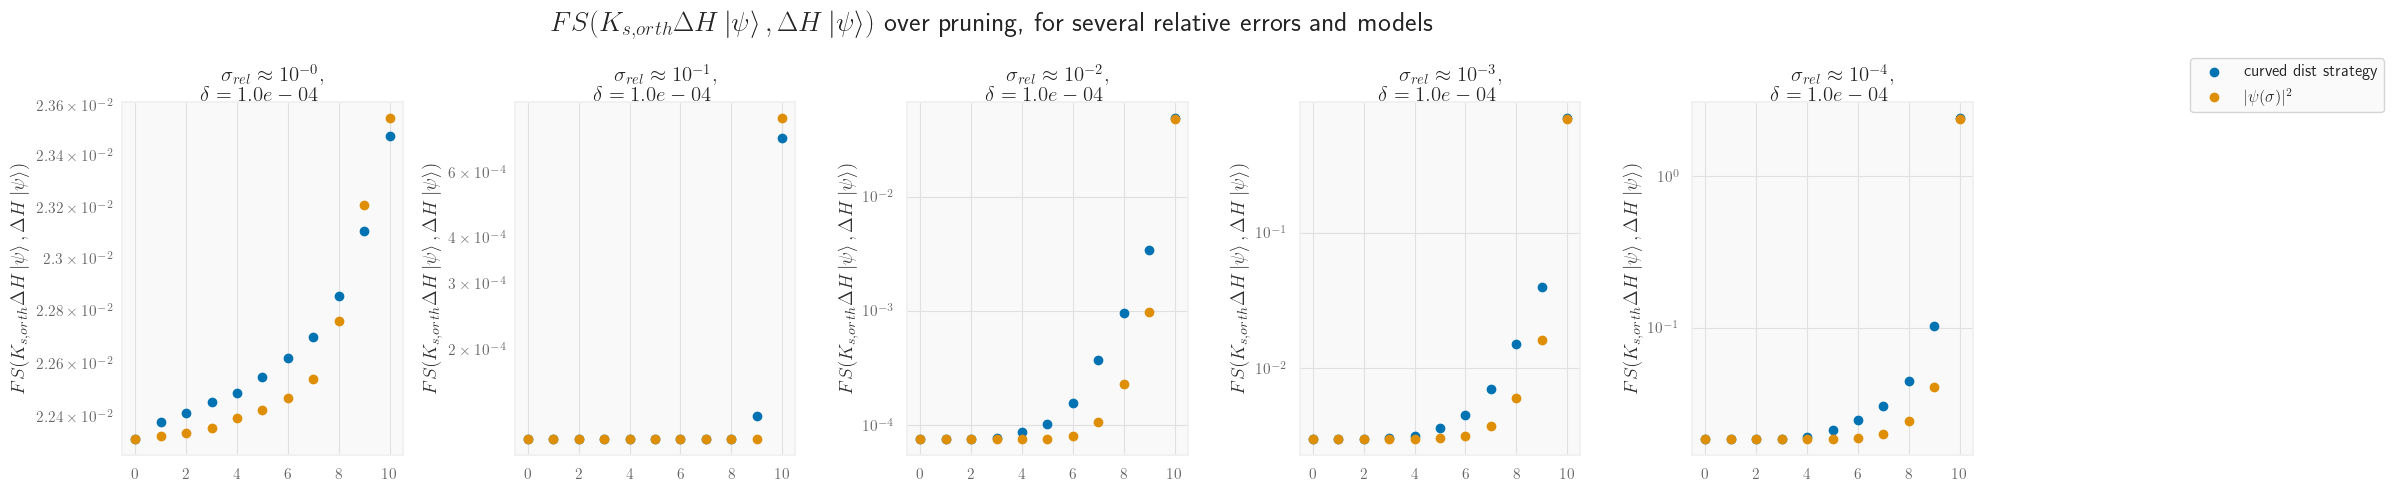

In [357]:
plot_multi_val_fixed_alpha(alpha=1, model_key=model_key, L=L, n_err=len(analysis.eval_s), diag_shift=diag_shift, key="ntk_orth")